In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
shared_folder_path = '/content/drive/My Drive/Data'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import random
seed = 12
np.random.seed(seed)

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Data/features_3_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [ ]:
data = df.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

# normalize
cols = X.columns
min_max_scaler = skp.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

In [ ]:
label_index = dict()
index_label = dict()
for i, x in enumerate(df.label.unique()):
    label_index[x] = i
    index_label[i] = x
print(label_index)
print(index_label)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


In [ ]:
df.label = [label_index[l] for l in df.label]
df_shuffle = df.sample(frac=1, random_state=seed).reset_index(drop=True)
df_shuffle.drop(['filename', 'length'], axis=1, inplace=True)
df_y = df_shuffle.pop('label')
df_X = df_shuffle

# split into train dev and test
X_train, df_test_valid_X, y_train, df_test_valid_y = skms.train_test_split(df_X, df_y, train_size=0.7, random_state=seed, stratify=df_y)
X_dev, X_test, y_dev, y_test = skms.train_test_split(df_test_valid_X, df_test_valid_y, train_size=0.66, random_state=seed, stratify=df_test_valid_y)

In [ ]:
print(f"Train set has {X_train.shape[0]} records out of {len(df_shuffle)} which is {round(X_train.shape[0]/len(df_shuffle)*100)}%")
print(f"Dev set has {X_dev.shape[0]} records out of {len(df_shuffle)} which is {round(X_dev.shape[0]/len(df_shuffle)*100)}%")
print(f"Test set has {X_test.shape[0]} records out of {len(df_shuffle)} which is {round(X_test.shape[0]/len(df_shuffle)*100)}%")

Train set has 6993 records out of 9990 which is 70%
Dev set has 1978 records out of 9990 which is 20%
Test set has 1019 records out of 9990 which is 10%


In [ ]:
scaler = skp.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_dev = pd.DataFrame(scaler.transform(X_dev), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

In [ ]:
import tensorflow as tf
import keras as k
tf.random.set_seed(seed)

In [ ]:
ACCURACY_THRESHOLD = 0.94

class myCallback(k.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):
            print("\n\nStopping training as we have reached %2.2f%% accuracy!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True

def trainModel(model, epochs, optimizer):
    batch_size = 128
    callback = myCallback()
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics='accuracy'
    )
    return model.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=epochs, 
                     batch_size=batch_size, callbacks=[callback])

def plotHistory(history):
    print("Max. Validation Accuracy",max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()

In [ ]:
model = k.models.Sequential([
    k.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.2),
    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.2),
    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.2),
    k.layers.Dense(10, activation='softmax'),
])
print(model.summary())
model_history = trainModel(model=model, epochs=500, optimizer='adam')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               14848     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 10)                6

In [ ]:
original_model_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
print("Original Model Accuracy: {:.4f}".format(original_model_accuracy))

Original Model Accuracy: 0.9284


In [ ]:
model.save('/content/drive/My Drive/Data/original_model.h5')

Compress

In [ ]:
!pip install numpy==1.23.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 43.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4


In [ ]:
!pip install -q tensorflow-model-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 6.0 MB/s eta 0:00:00


In [ ]:
import tensorflow_model_optimization as tfmot
from tensorflow import keras


Define the pruning parameters and apply pruning to the model

In [ ]:
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(target_sparsity=0.5, begin_step=0, frequency=100)
}

model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)


In [ ]:
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(target_sparsity=0.5, begin_step=2000, frequency=100)
}
try:
    model_for_pruning_history = trainModel(model=model_for_pruning, epochs=500, optimizer='adam')
except Exception as e:
    import traceback
    traceback.print_exc()

Epoch 1/500


Traceback (most recent call last):
  File "<ipython-input-19-8afa433fa3f2>", line 5, in <cell line: 4>
    model_for_pruning_history = trainModel(model=model_for_pruning, epochs=500, optimizer='adam')
  File "<ipython-input-11-8a613cc430d3>", line 16, in trainModel
    return model.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=epochs,
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.InvalidArgumentError: Graph execution error:

Detected at node 'sequential/prune_low_magnitude_dense/assert_greater_equal/Assert/AssertGuard/Assert' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      

Train the pruned model

In [ ]:

# Remove the pruning wrapper from the model
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)




In [ ]:
# Save the pruned model
model_for_export.save('/content/drive/My Drive/Data/pruned_model.h5')

Compress the pruned model using gzip

In [ ]:
import gzip
import shutil

with open('/content/drive/My Drive/Data/pruned_model.h5', 'rb') as f_in:
    with gzip.open('/content/drive/My Drive/Data/pruned_model.h5.gz', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [ ]:
model_for_export.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics='accuracy')

compare

In [ ]:
original_model_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
pruned_model_accuracy = model_for_export.evaluate(X_test, y_test, verbose=0)[1]

print("Original Model Accuracy: {:.4f}".format(original_model_accuracy))
print("Pruned Model Accuracy: {:.4f}".format(pruned_model_accuracy))


Original Model Accuracy: 0.9284
Pruned Model Accuracy: 0.9284


compare the sizes of the original model and the compressed pruned model

In [ ]:
import os

original_model_size = os.path.getsize('/content/drive/My Drive/Data/original_model.h5')
compressed_pruned_model_size = os.path.getsize('/content/drive/My Drive/Data/pruned_model.h5.gz')

print("Original Model Size: {} bytes".format(original_model_size))
print("Compressed Pruned Model Size: {} bytes".format(compressed_pruned_model_size))


Original Model Size: 723488 bytes
Compressed Pruned Model Size: 213468 bytes


In [ ]:
compression_ratio = os.path.getsize('/content/drive/My Drive/Data/original_model.h5') / os.path.getsize('/content/drive/My Drive/Data/pruned_model.h5.gz')
print(f"\nCompression ratio: {compression_ratio:.2f}")


Compression ratio: 3.39


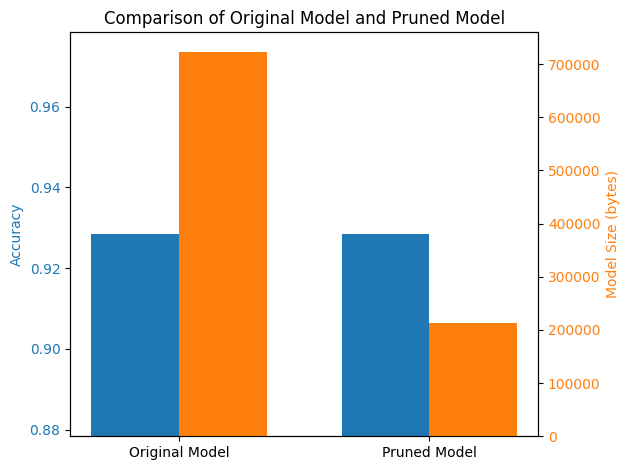

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data to plot
labels = ['Original Model', 'Pruned Model']
accuracy = [original_model_accuracy, pruned_model_accuracy]
model_sizes = [original_model_size, compressed_pruned_model_size]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax1 = plt.subplots()

# Plot accuracy
color = 'tab:blue'
ax1.set_ylabel('Accuracy', color=color)
ax1.bar(x - width/2, accuracy, width, label='Accuracy', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([min(accuracy) - 0.05, max(accuracy) + 0.05])

# Plot model sizes
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Model Size (bytes)', color=color)
ax2.bar(x + width/2, model_sizes, width, label='Model Size', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Set the x-axis labels and title
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.set_title('Comparison of Original Model and Pruned Model')

fig.tight_layout()
plt.show()
